# MOVIELENS RECOMMENDER SYSTEMS

## PROJECT OVERVIEW

In today's digital age, personalized recommendations are critical to enhancing user experiences across various platforms. One prime example is the movie industry, where vast catalogs of films can overwhelm users, making it challenging for them to find content that suits their unique tastes. 

The **MovieLens Recommender System** project aims to address this challenge by leveraging the MovieLens dataset, a rich source of user ratings and movie metadata, to develop a robust recommendation engine.

Through this project, we aim to demonstrate the potential of data-driven recommendations in creating tailored viewing experiences, helping users discover movies they'll love, and fostering greater engagement with the platform.


## BUSINESS UNDERSTANDING / BUSINESS QUESTION

In this project, we are trying to answer the following questions:

1. How can the MovieLens recommender system improve user satisfaction by delivering personalized movie recommendations based on user ratings and movie attributes?

2. How can this personalization increase user engagement and overall platform experience?


## PROBLEM STATEMENT

With the vast array of movies available, users often face the challenge of discovering films that match their unique tastes. This project seeks to address this issue by developing a recommendation system that offers tailored movie suggestions based on users' past ratings and preferences.


## OBJECTIVES

**1. Personalization:** - Provide highly personalized movie recommendations, aligning suggestions with individual tastes.  
**2. Engagement:** - Drive user engagement by offering relevant and diverse movie suggestions that encourage return visits.  
**3. Retention:** - Boost retention by consistently delivering fresh content tailored to evolving user preferences.


## KEY CHALLENGES

**1. Sparsity in User Ratings:**  
A significant number of users provide ratings for only a small subset of available movies, resulting in sparse data. This can hinder the accuracy of recommendations, especially for users with limited rating history.

**2. Cold Start Problem:**  
New users who have little or no historical data present a challenge in providing personalized recommendations. Developing effective methods to recommend relevant content from the start is crucial to enhancing user experience.

**3. Diversity:**  
It is essential to ensure that the recommendation system suggests a broad range of movies. This helps cater to varying user preferences, preventing the system from offering repetitive or narrow suggestions that may limit user satisfaction.


## STAKEHOLDERS

**1. Users:** - Individuals benefiting from personalized movie recommendations, including new users receiving tailored suggestions.  
**2. Business Owners:** - Organizations owning and operating the movie recommendation platform.  
**3. Product Managers:** - Responsible for the strategy, development, and success of the recommender system.  
**4. Marketing Team:** - Uses user insights to create targeted campaigns for user acquisition and retention.  
**5. Data Scientists and Software Engineers:** - Develop algorithms, analyze data, optimize performance, and maintain system infrastructure.  
**6. Content Providers:** - Supply and ensure the quality and relevance of movies for recommendations.  
**7. Investors and Stakeholders:** - Have a financial interest in the platform’s success and growth.


## SUCCESS METRICS

**Recommendation Accuracy:** - Evaluate quality using metrics like Precision@k and Recall@k.  
**Coverage:** - Ensure recommendations span diverse genres and user preferences.  
**User Engagement:** - Track metrics like click-through rates to assess effectiveness in improving interaction.


# Justification for Choosing the MovieLens Dataset

**1. Rich Data:** - Contains millions of user ratings and detailed movie metadata, enabling advanced recommendation techniques.  
**2. Well-Structured:** - Organized and accessible, making it easy for researchers and practitioners to work with.  
**3. Benchmarking:** - A standard benchmark in the research community, facilitating model comparisons.  
**4. Publicly Available:** - Accessible to promote transparency, reproducibility, and further research.  
**5. Variety of Sizes:** - Available in multiple sizes (100K, 1M, 10M ratings), offering flexibility for different use cases.  
**6. Real-World Application:** - Reflects diverse user preferences and movie attributes, aligning with media streaming services.  
**7. Historical Data:** - Includes temporal data, enabling the development of time-aware recommendation models.


### Use Cases and Applications

**1. Personalized Recommendations:**  
Provide tailored movie suggestions on streaming platforms like Netflix based on user preferences.

**2. Enhancing Engagement:**  
Recommend relevant content based on past viewing, boosting interaction and satisfaction.

**3. Improving Retention:**  
Offer dynamic, personalized content to keep users engaged and returning.

The MovieLens dataset is a strong foundation for building and evaluating recommender systems, with real-world relevance in media streaming.


## DATA UNDERSTANDING

In this project, we will use four CSV files—**links**, **movies**, **ratings**, and **tags**—to build a movie recommender system. Below is an overview of each dataset:

1. **Links:** - Provides relationships between MovieLens and external movie databases (e.g., IMDb, TMDb) for integrating additional movie data.

2. **Movies:** - Contains key movie information, including unique identifiers, titles, and genres, forming the base for content-based recommendations.

3. **Ratings:** - Includes user-specific ratings for movies, essential for collaborative filtering and understanding user preferences.

4. **Tags:** - Contains user-generated tags, adding another layer of personalization by enabling recommendations based on user-defined themes.


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from surprise import accuracy
from scipy.sparse import csr_matrix
import pickle
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import warnings


# Suppress warnings
warnings.filterwarnings('ignore')


### MOVIES csv file

In [2]:
# Load movies dataset
movies_df = pd.read_csv('movies.csv')
display(movies_df.head())
print('-------------------------------------------------------------------------')
display(movies_df.info())
print('-------------------------------------------------------------------------')
# Get summary statistics
print(movies_df.describe(include='all'))
print('-------------------------------------------------------------------------')



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


-------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

-------------------------------------------------------------------------
              movieId        title genres
count     9742.000000         9742   9742
unique            NaN         9737    951
top               NaN  Emma (1996)  Drama
freq              NaN            2   1053
mean     42200.353623          NaN    NaN
std      52160.494854          NaN    NaN
min          1.000000          NaN    NaN
25%       3248.250000          NaN    NaN
50%       7300.000000          NaN    NaN
75%      76232.000000          NaN    NaN
max     193609.000000          NaN    NaN
-------------------------------------------------------------------------


### Column Descriptions

**movieId**  
- Data Type: int64  
- Description: Unique identifier for each movie  
- Non-Null Values: 9742 (no missing values)

**title**  
- Data Type: object (string)  
- Description: The movie title  
- Non-Null Values: 9742 (no missing values)

**genres**  
- Data Type: object (string)  
- Description: A string of genres separated by a delimiter (e.g., "Action|Adventure|Comedy")  
- Non-Null Values: 9742 (no missing values)


### RATINGS csv file

In [3]:
# Load Ratings dataset (for extra movie information)
ratings_df = pd.read_csv('ratings.csv')
display(ratings_df.head())
print('-------------------------------------------------------------------------')
display(ratings_df.info())
print('-------------------------------------------------------------------------')
# Get summary statistics
print(ratings_df.describe(include='all'))
print('-------------------------------------------------------------------------')


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


-------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

-------------------------------------------------------------------------
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
-------------------------------------------------------------------------


### Column Descriptions

**1. userId:** - Unique integer identifier for each user, used to track individual activity.  
**2. movieId:** - Unique integer identifier for each movie, linking ratings to specific films.  
**3. rating:** - Floating-point number representing the user's rating for a movie (typically 1 to 5).  
**4. timestamp:** - Integer representing the exact time the rating was made (likely in Unix format).


 ### Ratings by User Count vs Movie Count (Scatter Plot)
 
This is a scatter plot of ratings per user against ratings per movie to  reveal patterns or anomalies, such as users who rate a disproportionate number of movies or movies with an unusual number of ratings.
we will plot this by Aggregating the ratings by userId and movieId and plot a scatter plot.



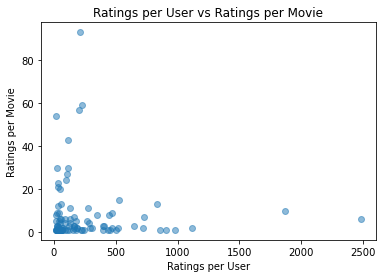

In [4]:
# Get the count of ratings per user and per movie
user_ratings = ratings_df.groupby('userId').size()
movie_ratings = ratings_df.groupby('movieId').size()

# Randomly sample 100 data points to make the lengths match
user_ratings_sample = user_ratings.sample(100, random_state=42)
movie_ratings_sample = movie_ratings.sample(100, random_state=42)

# Scatter plot
plt.scatter(user_ratings_sample, movie_ratings_sample, alpha=0.5)
plt.title('Ratings per User vs Ratings per Movie')
plt.xlabel('Ratings per User')
plt.ylabel('Ratings per Movie')
plt.show()


### LINKS csv file


In [5]:
# Load links dataset (for extra movie information)
link_df = pd.read_csv('links.csv')
display(link_df.head())
print('-------------------------------------------------------------------------')
display(link_df.info())
print('-------------------------------------------------------------------------')
# Get summary statistics
print(link_df.describe(include='all'))
print('-------------------------------------------------------------------------')



,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


-------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


None

-------------------------------------------------------------------------
             movieId        imdbId         tmdbId
count    9742.000000  9.742000e+03    9734.000000
mean    42200.353623  6.771839e+05   55162.123793
std     52160.494854  1.107228e+06   93653.481487
min         1.000000  4.170000e+02       2.000000
25%      3248.250000  9.518075e+04    9665.500000
50%      7300.000000  1.672605e+05   16529.000000
75%     76232.000000  8.055685e+05   44205.750000
max    193609.000000  8.391976e+06  525662.000000
-------------------------------------------------------------------------


### Dataset Purpose

This dataset is;

1. A mapping table that connects a movie's internal ID (movieId) with its external IDs (imdbId and tmdbId).

2. A reference dataset for integrating metadata from IMDb or TMDb to enrich a larger movie-related dataset (e.g., adding genres, ratings, or descriptions).

3. A foundational dataset for tasks like building recommendation systems, where movieId is used internally, while imdbId and tmdbId allow access to external metadata.

### Columns Description

**1. movieId:** - Unique identifier for movies, used to link with ratings or other attributes.  
**2. imdbId:** - Unique identifier for the movie on IMDb, useful for cross-referencing data.  
**3. tmdbId:** - Unique identifier for the movie on TMDb, used for accessing metadata and APIs.


### Key Observations:

Our links dataframe has 3 columns and 9742;

***movieId and imdbId*** are of type int64, meaning they contain integer values and 
both columns have no missing values (non-null count matches total row count).

***tmdbId***  is of type float64, indicating it contains numerical data but may include decimal points (even if the values are mostly integers). we also notice it has 8 missing values (9734 non-null out of 9742).

### Visualizing the Distribution of all three columns

<function matplotlib.pyplot.show(close=None, block=None)>

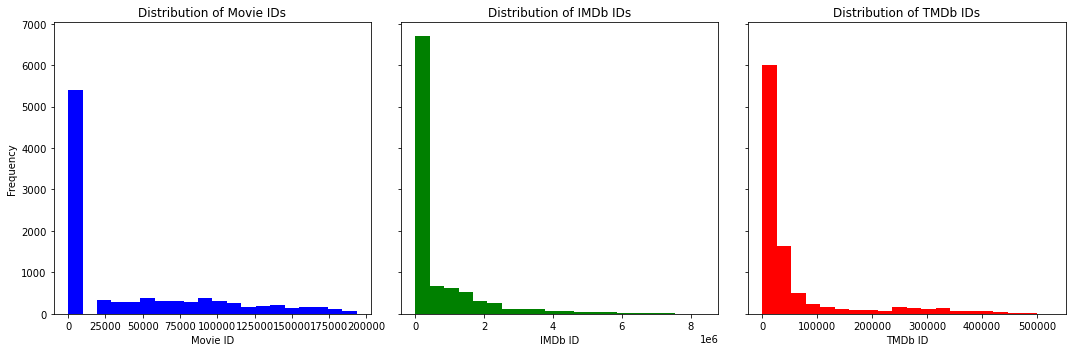

In [6]:
# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot the distributions for each column using plt.hist()
axes[0].hist(link_df['movieId'], bins=20, color='blue')
axes[0].set_title('Distribution of Movie IDs')
axes[0].set_xlabel('Movie ID')
axes[0].set_ylabel('Frequency')

axes[1].hist(link_df['imdbId'], bins=20, color='green')
axes[1].set_title('Distribution of IMDb IDs')
axes[1].set_xlabel('IMDb ID')

# For tmdbId, drop NaN values before plotting
axes[2].hist(link_df['tmdbId'].dropna(), bins=20, color='red')
axes[2].set_title('Distribution of TMDb IDs')
axes[2].set_xlabel('TMDb ID')

# Set the overall layout to prevent overlap
plt.tight_layout()
plt.show


### TAGS csv file

In [7]:
#read the file
tags=pd.read_csv('tags.csv')
# Display the first few rows of the dataframe
print("### Display the first few rows")
display(tags.head())
print('-------------------------------------------------------------------------')

# Display basic information about the dataframe
print("### DataFrame Information")
display(tags.info())
print('-------------------------------------------------------------------------')

# Get summary statistics
print("### Summary Statistics")
print(tags.describe(include='all'))
print('-------------------------------------------------------------------------')

# Get the unique tags
print("### Unique Tags")
unique_tags = tags['tag'].unique()
print('-------------------------------------------------------------------------')

# Display the first 10 unique tags
print("### First 10 Unique Tags")
print(unique_tags[:10])
print('-------------------------------------------------------------------------')

# Count missing values in 'tag' column
print("### Missing Values in 'tag' Column")
print(tags['tag'].isnull().sum())


### Display the first few rows


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


-------------------------------------------------------------------------
### DataFrame Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


None

-------------------------------------------------------------------------
### Summary Statistics
             userId        movieId               tag     timestamp
count   3683.000000    3683.000000              3683  3.683000e+03
unique          NaN            NaN              1589           NaN
top             NaN            NaN  In Netflix queue           NaN
freq            NaN            NaN               131           NaN
mean     431.149335   27252.013576               NaN  1.320032e+09
std      158.472553   43490.558803               NaN  1.721025e+08
min        2.000000       1.000000               NaN  1.137179e+09
25%      424.000000    1262.500000               NaN  1.137521e+09
50%      474.000000    4454.000000               NaN  1.269833e+09
75%      477.000000   39263.000000               NaN  1.498457e+09
max      610.000000  193565.000000               NaN  1.537099e+09
-------------------------------------------------------------------------
### Unique Tags
---------

### Columns Description

**userId (int64):** - Unique identifier for each user. A user can have multiple entries.  
**movieId (int64):** - Unique identifier for each movie, linked to multiple user tags.  
**tag (object):** - Text labels describing a movie (e.g., genres or personal descriptors).  
**timestamp (int64):** - Time when the tag was assigned, typically in Unix timestamp format.


### Tagging Trends By TimeStamp

A Line Plot Showing how the total number of tags has changed over time. This will help visualize trends or spikes in user tagging activity.

X-axis: Timestamp (grouped by time period like day, month, or year)

Y-axis: Total number of tags

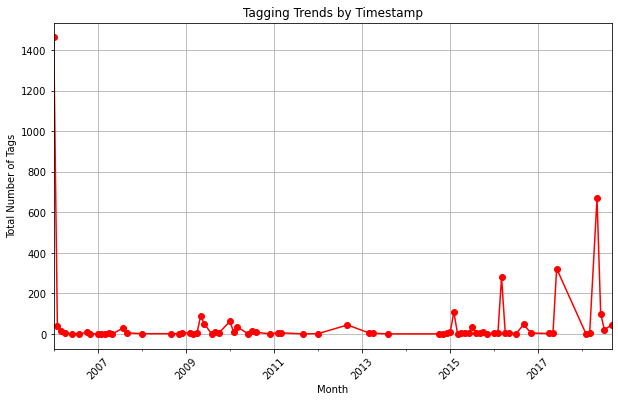

In [8]:
#Converting timestamp to datetime (assuming timestamp is in seconds)
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# Group by time period (e.g., month, year, or day)
tags['month'] = tags['timestamp'].dt.to_period('M')  # You can use 'D' for day, 'Y' for year

#Count number of tags per time period
tag_count_by_month = tags.groupby('month')['tag'].count()

# Plotting the trends
plt.figure(figsize=(10, 6))
tag_count_by_month.plot(kind='line', marker='o', color='red')
plt.title('Tagging Trends by Timestamp')
plt.xlabel('Month')
plt.ylabel('Total Number of Tags')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Exploratory Data Analysis

In [9]:
n_ratings = len(ratings_df)
n_movies = len(movies_df)
n_users = ratings_df['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")


Number of ratings: 100836
Number of unique movieId's: 9742
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.35


### What is the distribution of movie ratings?

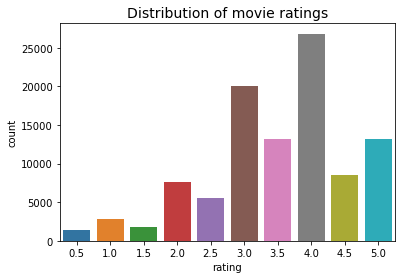

Mean global rating: 3.5.


In [10]:
sns.countplot(x='rating', data=ratings_df)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

print(f"Mean global rating: {round(ratings_df['rating'].mean(), 2)}.")


### Mean Rating Per User

In [11]:
mean_ratings = ratings_df.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}.")


Mean rating per user: 3.66.


### Which Movies are Most Frequently Rated?

In [12]:
movie_ratings = ratings_df.merge(movies_df, on='movieId')
top_movies = movie_ratings['title'].value_counts().head(10)
top_movies


title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

### What are the Lowest and Highest Rated Movies?

In [13]:
mean_ratings_movie = ratings_df.groupby('movieId')['rating'].mean()
lowest_rated = mean_ratings_movie.idxmin()
highest_rated = mean_ratings_movie.idxmax()

print(f"Lowest rated movie: {movies_df[movies_df['movieId'] == lowest_rated]['title'].values[0]}")
print(f"Highest rated movie: {movies_df[movies_df['movieId'] == highest_rated]['title'].values[0]}")


Lowest rated movie: Gypsy (1962)
Highest rated movie: Lamerica (1994)


## Bayesian Average

Bayesian Average is defined as:

$$
\text{Bayesian Average} = \frac{C \times m + R \times n}{n + m}
$$

Where:

- \( C \) represents our confidence,
- \( m \) represents our prior,
- \( n \) is the total number of reviews for movie \( i \),
- \( R \) is the average rating across all movies.


In [14]:
movie_stats = ratings_df.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [15]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [16]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.543

In [17]:
# apply bayesian_avg to all movies in our dataset.
bayesian_avg_ratings = ratings_df.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats = movie_stats.merge(movies_df[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that Shawshank Redemption, The Godfather, and Fight Club are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

In [18]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


### Exploring Movie Genres

To better analyze the genres and titles in the movie dataset, we need to perform some data cleaning. Specifically, the following tasks need to be addressed:

### 1. **Cleaning the 'genres' Column**

The `genres` column contains genre names as a single string, with genres separated by a pipe (`|`). For easier manipulation, we will split this column into a list of genres for each movie. This will allow for more efficient analysis of individual genres and their relationships to other attributes in the dataset.

### 2. **Extracting the Year from the 'title' Column**

The `title` column contains the year of release at the end of the movie title in parentheses. For better usability and to facilitate analysis based on year, we will extract the year from the title and store it in a new column called `year`. This will make it easier to work with the data when performing time-based analysis or sorting movies by release year.


In [19]:
# Split genres by pipe and store as a list
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split("|"))
movies_df.head()


,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Analyzing the Number of Movie Genres
Let's now check how many unique genres exist in the dataset.

In [20]:
from collections import Counter

# Count the frequency of each genre
genre_frequency = Counter(g for genres in movies_df['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")
genre_frequency


There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

### Top 5 Most Common Genres

In [21]:
# Display the most common genres
print("The 5 most common genres: \n", genre_frequency.most_common(5))


The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


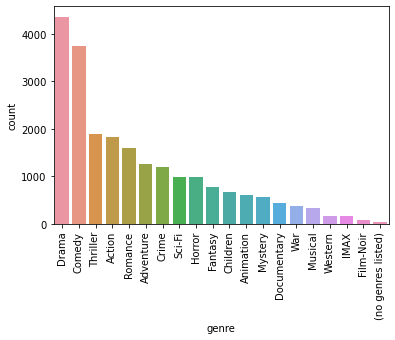

In [22]:
# Prepare the data for visualization
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

# Create a bar plot
sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()


## Data Preparation

## Generating a Sparse User-Item Interaction Matrix

The `generate_user_item_matrix` function is designed to create a sparse matrix that represents the interactions between users and movies. This matrix is essential for building recommender systems, particularly collaborative filtering models.

The resulting matrix is in **Compressed Sparse Row (CSR)** format, which efficiently stores large sparse matrices by only keeping track of non-zero values. This is particularly useful when most of the matrix values are zeros, as it saves memory and computational resources.

The function also returns several mappings that make it easier to access user and movie information by their indices. These mappings are necessary for matrix-based operations in recommendation systems, allowing us to efficiently map user and movie IDs to their corresponding indices.

### Summary

The `generate_user_item_matrix()` function outputs a sparse matrix along with four mapper dictionaries:

- **`user_mapper`**: Maps user ID to user index.
- **`movie_mapper`**: Maps movie ID to movie index.
- **`user_inv_mapper`**: Maps user index to user ID.
- **`movie_inv_mapper`**: Maps movie index to movie ID.

These dictionaries are essential because they map which row/column of the utility matrix corresponds to which user or movie ID.

The user-item matrix itself is a `scipy.sparse.csr_matrix`, which stores the data in a sparse format, keeping memory usage efficient.


In [23]:
from scipy.sparse import csr_matrix

def generate_user_item_matrix(df):
    """
    Generates a sparse user-item interaction matrix (CSR Matrix) from the ratings dataframe.
    
    Args:
        df: A pandas DataFrame with columns: userId, movieId, rating
    
    Returns:
        - X: Sparse matrix (CSR format)
        - user_to_idx: Dictionary mapping user ids to user indices
        - movie_to_idx: Dictionary mapping movie ids to movie indices
        - idx_to_user: Dictionary mapping indices to user ids
        - idx_to_movie: Dictionary mapping indices to movie ids
    """
    # Check for missing columns
    required_columns = ['userId', 'movieId', 'rating']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {', '.join(required_columns)}")

    # Create mappings for user and movie indices
    user_to_idx = {user_id: idx for idx, user_id in enumerate(df['userId'].unique())}
    movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(df['movieId'].unique())}
    
    # Reverse mappings (index to id)
    idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
    idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}

    # Map user/movie ids to indices
    user_indices = df['userId'].map(user_to_idx.get).values
    movie_indices = df['movieId'].map(movie_to_idx.get).values

    # Create the sparse matrix (CSR format)
    interaction_matrix = csr_matrix((df['rating'], (user_indices, movie_indices)),
                                    shape=(len(user_to_idx), len(movie_to_idx)))

    return interaction_matrix, user_to_idx, movie_to_idx, idx_to_user, idx_to_movie


### Create the User-Item Interaction Matrix

In [24]:
# Generate the user-item interaction matrix (CSR format) along with mappings
interaction_matrix, user_to_idx, movie_to_idx, idx_to_user, idx_to_movie = generate_user_item_matrix(ratings_df)


### Calculate and Evaluate Matrix Sparsity


In [25]:
# Calculate and print the sparsity of the user-item matrix
total_entries = interaction_matrix.shape[0] * interaction_matrix.shape[1]
rated_entries = interaction_matrix.nnz
sparsity_percentage = (rated_entries / total_entries) * 100
print(f"Matrix Sparsity: {sparsity_percentage:.2f}%")


Matrix Sparsity: 1.70%


### Evaluate Ratings Distribution per User and Movie

In [26]:
# Evaluate the number of ratings per user and movie
ratings_per_user = interaction_matrix.getnnz(axis=1)  # Number of ratings per user
ratings_per_movie = interaction_matrix.getnnz(axis=0)  # Number of ratings per movie

# Output the most/least active users and movies
print(f"Most active user rated {ratings_per_user.max()} movies.")
print(f"Least active user rated {ratings_per_user.min()} movies.")
print(f"Most rated movie has {ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {ratings_per_movie.min()} ratings.")


Most active user rated 2698 movies.
Least active user rated 20 movies.
Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


### Distribution of Ratings per User and Movie

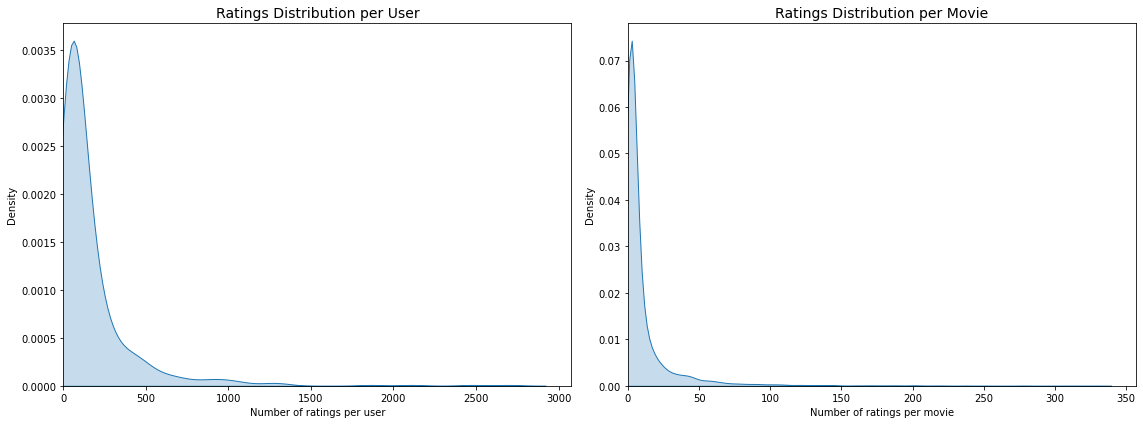

In [27]:
# Plot the distribution of ratings per user and per movie
plt.figure(figsize=(16, 6))

# Distribution of ratings per user
plt.subplot(1, 2, 1)
sns.kdeplot(ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Ratings Distribution per User", fontsize=14)
plt.xlabel("Number of ratings per user")
plt.ylabel("Density")

# Distribution of ratings per movie
plt.subplot(1, 2, 2)
sns.kdeplot(ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Ratings Distribution per Movie", fontsize=14)
plt.xlabel("Number of ratings per movie")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


## Item-item Recommendations with k-Nearest Neighbors

In this step, we will implement item-item recommendations using k-Nearest Neighbors (k-NN). This method recommends movies similar to one a user has interacted with, based on user engagement vectors.

### Process:
- **Input**: A function takes a `movie_id` and the `user-item matrix X`.
- **Similarity Calculation**: We use **cosine similarity** (but you can experiment with Euclidean or Manhattan distance).
- **Top k Similar Movies**: The function returns the top `k` most similar movies based on similarity scores.

This approach helps recommend movies that are similar to a user's previous ratings or interactions.


In [28]:
def find_similar_movies(movie_id, interaction_matrix, movie_to_idx, idx_to_movie, k=10, metric='cosine'):
    """
    Finds k-nearest neighbors for a given movie based on user interactions.
    
    Args:
        movie_id: The ID of the movie of interest
        interaction_matrix: The user-item interaction matrix (CSR format)
        movie_to_idx: Dictionary mapping movie ids to indices
        idx_to_movie: Dictionary mapping indices to movie ids
        k: Number of similar movies to retrieve
        metric: Distance metric for kNN (default is 'cosine')
        
    Returns:
        List of k similar movie IDs
    """
    # Transpose the matrix to treat movies as rows (i.e., each row represents a movie)
    interaction_matrix = interaction_matrix.T
    
    # Get the index of the movie
    movie_idx = movie_to_idx[movie_id]
    
    # Get the vector of the movie
    movie_vector = interaction_matrix[movie_idx]
    
    # Reshape the movie vector for the kNN algorithm
    if isinstance(movie_vector, np.ndarray):
        movie_vector = movie_vector.reshape(1, -1)
    
    # Initialize the kNN model
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(interaction_matrix)
    
    # Find the k-nearest neighbors (excluding the movie itself)
    neighbors = kNN.kneighbors(movie_vector, return_distance=False)
    
    # Convert the indices of the nearest neighbors to movie IDs
    similar_movie_ids = [idx_to_movie[idx] for idx in neighbors[0][1:]]
    
    return similar_movie_ids


In [29]:

# Movie ID of interest (e.g., Toy Story)
from sklearn.neighbors import NearestNeighbors

movie_id = 1

# Find similar movies using k-NN (Cosine similarity)
similar_movie_ids = find_similar_movies(movie_id, interaction_matrix, movie_to_idx, idx_to_movie, k=10, metric='cosine')

# Display the results
movie_titles = dict(zip(movies_df['movieId'], movies_df['title']))

print(f"Because you watched {movie_titles[movie_id]} You may also Like:")
for similar_movie_id in similar_movie_ids:
    print(f"- {movie_titles[similar_movie_id]}")


Because you watched Toy Story (1995) You may also Like:
- Toy Story 2 (1999)
- Jurassic Park (1993)
- Independence Day (a.k.a. ID4) (1996)
- Star Wars: Episode IV - A New Hope (1977)
- Forrest Gump (1994)
- Lion King, The (1994)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Mission: Impossible (1996)
- Groundhog Day (1993)
- Back to the Future (1985)


###  Experiment with Different Metrics

In [30]:
# Experiment with 'euclidean' or 'manhattan' distance
similar_movie_ids_euclidean = find_similar_movies(movie_id, interaction_matrix, movie_to_idx, idx_to_movie, k=10, metric='euclidean')

print(f"\nBecause you watched {movie_titles[movie_id]} You may also like (Euclidean):")
for similar_movie_id in similar_movie_ids_euclidean:
    print(f"- {movie_titles[similar_movie_id]}")



Because you watched Toy Story (1995) You may also like (Euclidean):
- Toy Story 2 (1999)
- Mission: Impossible (1996)
- Independence Day (a.k.a. ID4) (1996)
- Bug's Life, A (1998)
- Nutty Professor, The (1996)
- Willy Wonka & the Chocolate Factory (1971)
- Babe (1995)
- Groundhog Day (1993)
- Mask, The (1994)
- Honey, I Shrunk the Kids (1989)


### Handling the Cold-Start Problem

In [31]:
# Convert the Genres Column into Binary Features
n_movies = movies_df['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

# Extract unique genres from the dataset
genres = set(g for G in movies_df['genres'] for g in G)

# Add a binary column for each genre
for g in genres:
    movies_df[g] = movies_df.genres.transform(lambda x: int(g in x))

# Create a new DataFrame with binary genre features
movie_genres = movies_df.drop(columns=['movieId', 'title', 'genres'])

# Display the first few rows
movie_genres.head()


There are 9742 unique movies in our movies dataset.


,Drama,Film-Noir,IMAX,Fantasy,Animation,War,Romance,Musical,Western,Mystery,Horror,(no genres listed),Documentary,Sci-Fi,Comedy,Adventure,Thriller,Crime,Children,Action
0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [32]:
# Compute the Cosine Similarity Matrix for Movie Genres
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between movies based on genre features
cosine_sim = cosine_similarity(movie_genres, movie_genres)

# Print the shape of the cosine similarity matrix
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")


Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [33]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies_df['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0] 

# Example usage
title = movie_finder('toy stor')
print(title) 


Toy Story (1995)


### Generate Recommendations for Similar Movies(Fuzzywuzzy)

In [34]:
movie_idx = dict(zip(movies_df['title'], list(movies_df.index)))
idx = movie_idx['Toy Story (1995)']
n_recommendations = 10

sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations + 1)]

similar_movies = [i[0] for i in sim_scores]
print(f"Because you watched {title}:")
print(movies_df['title'].iloc[similar_movies])


Because you watched Toy Story (1995):
1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object


### Function to Get Content-Based Recommendations

In [35]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations + 1)]
    similar_movies = [i[0] for i in sim_scores]
    
    print(f"Because you watched {title}:")
    print(movies_df['title'].iloc[similar_movies])

# Example usage
get_content_based_recommendations('Honey, I Shrunk ', 10)


Because you watched Honey, I Shrunk the Kids (1989):
478                              Super Mario Bros. (1993)
559                                      Space Jam (1996)
8806                                          Home (2015)
9169           Wizards of Waverly Place: The Movie (2009)
1357                                Borrowers, The (1997)
2233                                  Time Bandits (1981)
3629                    Bill & Ted's Bogus Journey (1991)
5122                       *batteries not included (1987)
5517    Ewok Adventure, The (a.k.a. Caravan of Courage...
5523                   Ewoks: The Battle for Endor (1985)
Name: title, dtype: object


### Collaborative Filtering with Surprise

In [36]:
# Prepare the data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Splitting the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)


In [37]:
# Instantiate SVD algorithm
SVD_algor = SVD()

# Train the SVD model
SVD_algor.fit(trainset)

# Make predictions for the test set
predictions = SVD_algor.test(testset)

# Evaluate the model
svd_rmse = accuracy.rmse(predictions)
print(f"SVD RMSE: {svd_rmse}")


RMSE: 0.8883
SVD RMSE: 0.8882586906266631


### KNN Basic Algorithm


In [38]:
# Instantiate KNN algorithm (user-based collaborative filtering)
KNN_algor = KNNBasic(sim_options={'user_based': True})

# Train the KNN model
KNN_algor.fit(trainset)

# Make predictions for the test set
predictions = KNN_algor.test(testset)

# Evaluate the model
knn_rmse = accuracy.rmse(predictions)
print(f"KNN RMSE: {knn_rmse}")


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9586
KNN RMSE: 0.9585768152782342


### Model Comparison


In [39]:
# Store RMSE results for both models
results = {
    "SVD": [svd_rmse],
    "KNN": [knn_rmse]
}

# Convert the dictionary to a DataFrame for easier comparison
results_df = pd.DataFrame(results).T
results_df = results_df.rename(columns={0: "RMSE"})
results_df.sort_values(by='RMSE', ascending=True)


,RMSE
SVD,0.888259
KNN,0.958577


In [40]:
# # Save the KNN model to a file
# file_name = 'knn_model.pkl'
# with open(file_name, 'wb') as file:
#     pickle.dump(KNN_algor, file)


### Web Scraping for Movie Metadata (Images and URLs)

In [41]:
# the web scrapper is commented because of its long run time(70 mins)
# # Create empty columns with null values
# link_df['url'] = np.nan
# link_df['img_url'] = np.nan


# for idx, tmdbId in tqdm(enumerate(link_df['tmdbId']), total = len(link_df['tmdbId'])):
#     try:
#         # Get url
#         url = 'https://www.themoviedb.org/movie/' + str(tmdbId)
#         link_df['url'][idx] = url

#         # assign the response to a object
#         response = requests.get(url)

#         # Use BeautifulSoup() to create a BeautifulSoup object from a response text content
#         soup = BeautifulSoup(response.text, 'html.parser')

#         # Find image container
#         obj = soup.find('div', 'image_content backdrop').img

#         # Get image url
#         image_url = 'https://www.themoviedb.org' + obj.get('data-src')

#         # Link image url
#         link_df['img_url'][idx] = image_url
#     except AttributeError:
#         image_url = 'https://www.firstcolonyfoundation.org/wp-content/uploads/2022/01/no-photo-available.jpeg'
        
#         link_df['img_url'][idx] = image_url

### Save the Scrapped Data

In [42]:
# # Save the scraped metadata (URLs and Image URLs)
# link_df.to_csv('link_df.csv', index=False)


In [43]:
links_df = pd.read_csv('links_df.csv')

In [44]:
links_df

,movieId,imdbId,tmdbId,url,img_url
0,1,114709,862.0,https://www.themoviedb.org/movie/862.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
1,2,113497,8844.0,https://www.themoviedb.org/movie/8844.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
2,3,113228,15602.0,https://www.themoviedb.org/movie/15602.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
3,4,114885,31357.0,https://www.themoviedb.org/movie/31357.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
4,5,113041,11862.0,https://www.themoviedb.org/movie/11862.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
...,...,...,...,...,...
9737,193581,5476944,432131.0,https://www.themoviedb.org/movie/432131.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
9738,193583,5914996,445030.0,https://www.themoviedb.org/movie/445030.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
9739,193585,6397426,479308.0,https://www.themoviedb.org/movie/479308.0,https://www.themoviedb.org/t/p/w300_and_h450_b...
9740,193587,8391976,483455.0,https://www.themoviedb.org/movie/483455.0,https://www.themoviedb.org/t/p/w300_and_h450_b...


### Prepare data for recomemdation


In [45]:
# Merge movies data with links (scraped metadata)
merged_df = pd.merge(movies_df, link_df, on='movieId')
merged_df.head()


,movieId,title,genres,Drama,Film-Noir,IMAX,Fantasy,Animation,War,Romance,...,Documentary,Sci-Fi,Comedy,Adventure,Thriller,Crime,Children,Action,imdbId,tmdbId
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,0,1,1,0,0,...,0,0,1,1,0,0,1,0,114709,862.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,113497,8844.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,113228,15602.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,114885,31357.0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,113041,11862.0


### Load the Best Model (KNN)

In [46]:
# Load the saved KNN model
file_name = 'knn_model.pkl'
with open(file_name, 'rb') as file:
    loaded_model = pickle.load(file)


### Make Movie Recommendations for a Specific User

In [47]:
user_id = 2  # Example: User with ID 2

# Get the list of movies already rated by the user
user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()

# Get the list of unrated movies
unrated_movies = merged_df[~merged_df['movieId'].isin(user_movies)]

# Get top-10 movie recommendations for the user
k = 10
user_recommendations = loaded_model.get_neighbors(user_id, k=k)

# Get the recommended movies from the unrated list
recommended_movies = unrated_movies[unrated_movies['movieId'].isin(user_recommendations)]
recommended_movies


,movieId,title,genres,Drama,Film-Noir,IMAX,Fantasy,Animation,War,Romance,...,Documentary,Sci-Fi,Comedy,Adventure,Thriller,Crime,Children,Action,imdbId,tmdbId
21,22,Copycat (1995),"[Crime, Drama, Horror, Mystery, Thriller]",1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,112722,1710.0
225,261,Little Women (1994),[Drama],1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,110367,9587.0
244,282,Nell (1994),[Drama],1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,110638,1945.0
346,389,"Colonel Chabert, Le (1994)","[Drama, Romance, War]",1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,109454,41580.0
429,492,Manhattan Murder Mystery (1993),"[Comedy, Mystery]",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,107507,10440.0
496,574,Spanking the Monkey (1994),"[Comedy, Drama]",1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,111252,17600.0
497,575,"Little Rascals, The (1994)","[Children, Comedy]",0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,110366,10897.0
508,590,Dances with Wolves (1990),"[Adventure, Drama, Western]",1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,99348,581.0


### Display Recommendations

In [48]:
# Display the recommended movies with their metadata (title, genres, image URL, and movie URL)
recommended_movies[['movieId', 'title', 'genres']] 


,movieId,title,genres
21,22,Copycat (1995),"[Crime, Drama, Horror, Mystery, Thriller]"
225,261,Little Women (1994),[Drama]
244,282,Nell (1994),[Drama]
346,389,"Colonel Chabert, Le (1994)","[Drama, Romance, War]"
429,492,Manhattan Murder Mystery (1993),"[Comedy, Mystery]"
496,574,Spanking the Monkey (1994),"[Comedy, Drama]"
497,575,"Little Rascals, The (1994)","[Children, Comedy]"
508,590,Dances with Wolves (1990),"[Adventure, Drama, Western]"
